In [ ]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models, Model, optimizers, regularizers
from keras.layers import Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/gdrive


In [ ]:
import pathlib
data_dir = "/content/drive/MyDrive/thesis_code/prajwol_amatya/train_seg_data"
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/gdrive/MyDrive/RiceDisease/Train_seg_data')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2550


In [ ]:
disease_images_dict = {
    'Blast': list(data_dir.glob('Blast/*')),
    'Blight': list(data_dir.glob('Blight/*')),
    'BrownSpot': list(data_dir.glob('BrownSpot/*')),
    'Hispa': list(data_dir.glob('Hispa/*')),
    'SheathBlight': list(data_dir.glob('SheathBlight/*'))
}

In [ ]:
disease_labels_dict = {
    'Blast': 0,
    'Blight': 1,
    'BrownSpot': 2,
    'Hispa': 3,
    'SheathBlight': 4
}

In [ ]:
img = cv2.imread(str(disease_images_dict['Blast'][0]))
img.shape

(256, 256, 3)

In [ ]:
IMAGE_SHAPE = (224, 224)
cv2.resize(img, IMAGE_SHAPE).shape

(224, 224, 3)

In [ ]:
X, y = [], []

for disease_name, images in disease_images_dict.items():
  for image in images:
    img = cv2.imread(str(image))
    resized_img = cv2.resize(img, (224,224))
    X.append(resized_img)
    y.append(disease_labels_dict[disease_name])

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

In [ ]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [ ]:
img_height, img_width = 224,224
model_base = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, pooling='max', input_shape=(img_height, img_width, 3))

In [ ]:
model_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
num_of_disease = 5

In [ ]:
for layer in model_base.layers:
  layer.trainable = False
model = models.Sequential()
model.add(model_base)
model.add(layers.Flatten())
model.add(layers.Dense(128,activation=('relu'), kernel_regularizer=regularizers.l2(0.01)))
Dropout(0.3)
model.add(layers.Dense(64, activation=('relu'), kernel_regularizer=regularizers.l2(0.01)))
Dropout(0.3)
model.add(layers.Dense(num_of_disease, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten_7 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               163968    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 325       
Total params: 2,430,533
Trainable params: 172,549
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
learning_rate = 0.001
epochs = 200
#sgd=optimizers.SGD(lr=learning_rate,momentum=.9,nesterov=False)
adam=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/thesis_code/prajwol_amatya/mobile_net_v2.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=adam, metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=epochs, validation_data=(X_test_scaled,y_test), callbacks=[checkpoint])

Epoch 1/200
56/56 [==============================] - 8s 91ms/step - loss: 3.4805 - acc: 0.7922 - val_loss: 2.6886 - val_acc: 0.8954

Epoch 00001: val_acc improved from -inf to 0.89542, saving model to /content/gdrive/MyDrive/Colab Notebooks/RiceDisease/mobile_net_v2.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
56/56 [==============================] - 4s 63ms/step - loss: 2.3230 - acc: 0.9311 - val_loss: 2.1131 - val_acc: 0.9190

Epoch 00002: val_acc improved from 0.89542 to 0.91895, saving model to /content/gdrive/MyDrive/Colab Notebooks/RiceDisease/mobile_net_v2.h5
Epoch 3/200
56/56 [==============================] - 4s 68ms/step - loss: 1.8599 - acc: 0.9473 - val_loss: 1.8826 - val_acc: 0.8837

Epoch 00003: val_acc did not improve from 0.91895
Epoch 4/200
56/56 [==============================] - 4s 63ms/step - loss: 1.5145 - acc: 0.9641 - val_loss: 1.5080 - val_acc: 0.9229

Epoch 00004: val_acc improved from 0.91895 to 0.92288, saving model to /content/gdrive/MyDrive/Colab Notebooks/RiceDisease/mobile_net_v2.h5
Epoch 5/200
56/56 [==============================] - 3s 62ms/step - loss: 1.2724 - acc: 0.9725 - val_loss: 1.2816 - val_acc: 0.9320

Epoch 00005: val_acc improved from 0.92288 to 0.93203, saving model to /content/gdrive/MyDrive/Colab Notebooks/RiceDisease/mobile_net_v2.h

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

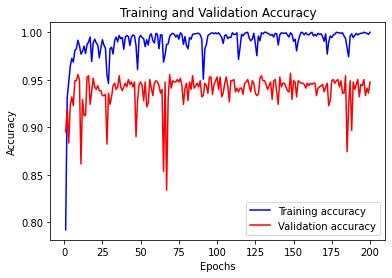

In [ ]:
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

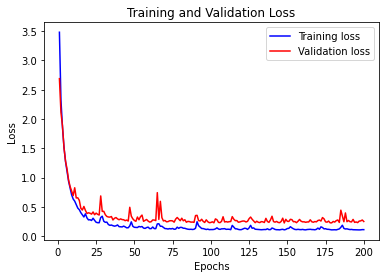

In [ ]:
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


In [ ]:
import pathlib
data_dir_test = "/content/drive/MyDrive/thesis_code/prajwol_amatya/Test_seg_data"
data_dir_test = pathlib.Path(data_dir_test)
data_dir_test

PosixPath('/content/gdrive/MyDrive/RiceDisease/Test_seg_data')

In [ ]:
image_count = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count)

250


In [ ]:
disease_images_dict_test = {
    'Blast': list(data_dir_test.glob('Blast/*')),
    'Blight': list(data_dir_test.glob('Blight/*')),
    'BrownSpot': list(data_dir_test.glob('BrownSpot/*')),
    'Hispa': list(data_dir_test.glob('Hispa/*')),
    'SheathBlight': list(data_dir_test.glob('SheathBlight/*'))
}

In [ ]:
X_t, y_t = [], []

for disease_name, images in disease_images_dict_test.items():
  for image in images:
    img = cv2.imread(str(image))
    resized_img = cv2.resize(img, (224,224))
    X_t.append(resized_img)
    y_t.append(disease_labels_dict[disease_name])

In [ ]:
len(X_t)

250

In [ ]:
X_t = np.array(X_t)
y_t = np.array(y_t)

In [ ]:
X_t_scaled = X_t / 255

In [ ]:
model = models.load_model("/content/drive/MyDrive/thesis_code/prajwol_amatya/mobile_net_v2.h5")

In [ ]:
Y_pred = model.predict(X_t_scaled)

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
cm = confusion_matrix(y_t, y_pred)
print(cm)

[[41  1  5  0  3]
 [ 0 49  0  0  1]
 [ 2  0 47  1  0]
 [ 0  0  0 50  0]
 [ 0  1  0  0 49]]


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
  import itertools
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Confusion matrix, without normalization')
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
      plt.ylabel('True Label')
      plt.xlabel('Predicted Label')
      plt.tight_layout()

Confusion matrix, without normalization


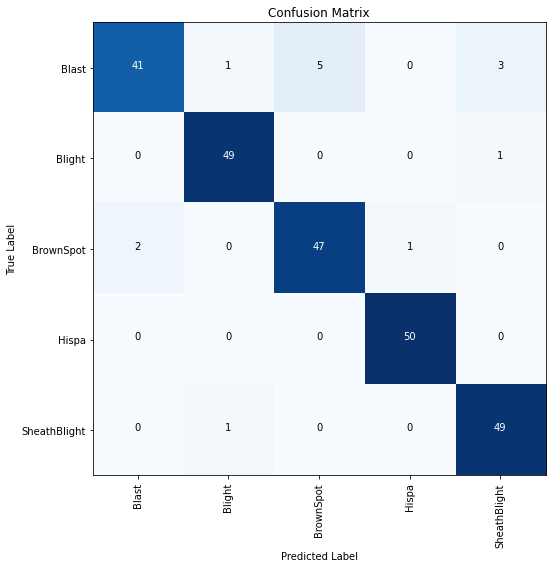

In [ ]:
plot_confusion_matrix(cm, classes=['Blast','Blight','BrownSpot','Hispa','SheathBlight'], title='Confusion Matrix', normalize=False)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("Accuracy %.3f" % accuracy_score(y_t, y_pred))
print("Precision: %.3f" % precision_score(y_t, y_pred, average='weighted'))
print('Recall: %.3f' % recall_score(y_t, y_pred, average='weighted'))
print('F1 score: %.3f' % f1_score(y_t, y_pred, average='weighted'))

Accuracy 0.944
Precision: 0.945
Recall: 0.944
F1 score: 0.943
